# Decoding Methods

References:
- [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
- [How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)


<a href="https://colab.research.google.com/github/paulaceccon/deep-learning-studies/blob/main/notebooks/generative_models/decoding_methods/decoding_methods.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
def get_device():
    return "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
torch_device = get_device()
print(torch_device)

mps


In [4]:
checkpoint = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint, pad_token_id=tokenizer.eos_token_id).to(torch_device)

## Decoding Methods

Generative models that produce text, like autoregressive language models, rely on the context of previously generated elements to determine the next element in the output sequence. These models find widespread use in natural language processing tasks such as text generation, language translation, and speech recognition.

In the context of task-specific heads like sequence or token classification, generating predictions is relatively straightforward. The model produces logits, and we can derive the final prediction by either taking the maximum value to identify the predicted class or applying a softmax function to get the predicted probabilities for each class. However, when it comes to text generation, an additional step called decoding is required.

Decoding in text generation is the process of converting the model's probabilistic output into coherent and meaningful text. The autoregressive model generates text one element at a time, usually starting with a special token or a seed input. Once an element is generated, it is appended to the input sequence, and the generation process continues until the desired sequence length is achieved or an end token is generated, indicating the completion of the text generation. This autoregressive decoding process allows the model to gradually build the text based on the context of the previously generated elements, resulting in fluent and contextually relevant text generation.

But how are these probabilities generated?

In simple terms, these models are designed to predict the likelihood of encountering a sequence of words (tokens) in a text, based on some initial starting words. The objective is to estimate the probability $P(y|x)$ of a sequence of tokens $y = y_1, ..., y_t$ appearing in the text, given a specific starting prompt $x = x_1, ..., x_k$. However, directly estimating this probability for all possible sequences of tokens and starting prompts is extremely challenging due to the enormous amount of data to consider. To tackle this problem, a common approach is to utilize the chain rule of probability. This rule allows us to break down the complex probability of observing a whole sequence of tokens, given a starting prompt, into a series of simpler, conditional probabilities:

$$P(\mathbf{y}|\mathbf{x}) = \prod_{t=1}^{T} P(y_t | y_{<t}, \mathbf{x})$$

Under the hood, these models generate predictions through the computation of log probabilities. Instead of directly working with raw probabilities, which can sometimes lead to numerical instability when dealing with small values, these models utilize the logarithm of probabilities, known as log probabilities:

$$\log P(\mathbf{y}|\mathbf{x}) = \sum_{t=1}^{T} P(y_t | y_{<t}, \mathbf{x})$$

The log probabilities allow for more stable and efficient computations, particularly when dealing with very large or very small probabilities.

Because language model generates logits, representing the likelihood of each token in the vocabulary, to determine the next token we apply the softmax function to convert logits into a probability distribution:

$$P(y_t=w_i | y_{<t}, \mathbf{x}) = \mathrm{softmax}(z_t, i)$$

In decoding methods, the main objective is to find the most likely sequence $\hat{y}$ based on the language model's predictions:

$$\hat{y} = \underset{y}{\mathrm{argmax}} P(\mathbf{y}|\mathbf{x})$$

However, directly computing $\hat{y}$ would require evaluating every possible sequence, which is computationally infeasible. To overcome this challenge, we use approximation techniques instead. 


### Greedy Decoding

In this method, the model selects the most probable token at each step based on its conditional probability. I.e,  the model chooses the token with the highest probability at the current step without considering future context:

$$\hat{y}_t = \underset{y_t}{\mathrm{argmax}} P(y_t |y_{< t}, \mathbf{x})$$

Greedy decoding is simple and efficient but may lead to suboptimal solutions.

In [10]:
def generate_with_greedy_search(prompt: str, iterations: int=6):
    # Encode the prompt using the tokenizer
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)
    
    # Initialize lists to store the generated tokens, logits, and probabilities
    generated_tokens = input_ids.tolist()[0]
    all_logits = []
    all_probs = []
    
    # Generate text using greedy search
    with torch.no_grad():
        for i in range(iterations): 
            output = model(input_ids)
        
            # Extract the logits for the generated text
            logits = output.logits[:, -1, :]
            all_logits.append(logits.cpu().numpy().squeeze())
            
            # Calculate probabilities using softmax
            probs = torch.softmax(logits, dim=-1)
            all_probs.append(probs.cpu().numpy().squeeze())
            
            # Choose the token with the highest logit value using greedy search
            next_token_id = torch.argmax(logits, dim=-1)
            
            # Append the new token to the list of generated tokens
            generated_tokens.append(next_token_id.item())
            
            # Update the input_ids for the next iteration
            input_ids = torch.cat((input_ids, next_token_id.unsqueeze(1)), dim=1).to(model.device)
            
            print(f"Iteration {i}: {generated_tokens}")
    
    # Decode the generated output to text
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    print(f"Generated text: {generated_text}")
        
    return all_logits, all_probs

prompt = "Tomorrow"
all_logits, all_probs = generate_with_greedy_search(prompt)

Iteration 0: [49488, 11]
Iteration 1: [49488, 11, 314]
Iteration 2: [49488, 11, 314, 1183]
Iteration 3: [49488, 11, 314, 1183, 307]
Iteration 4: [49488, 11, 314, 1183, 307, 736]
Iteration 5: [49488, 11, 314, 1183, 307, 736, 13]
Generated text: Tomorrow, I'll be back.


/Users/paulaceccon/Library/Caches/pypoetry/virtualenvs/ml-2x9GxN3b-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


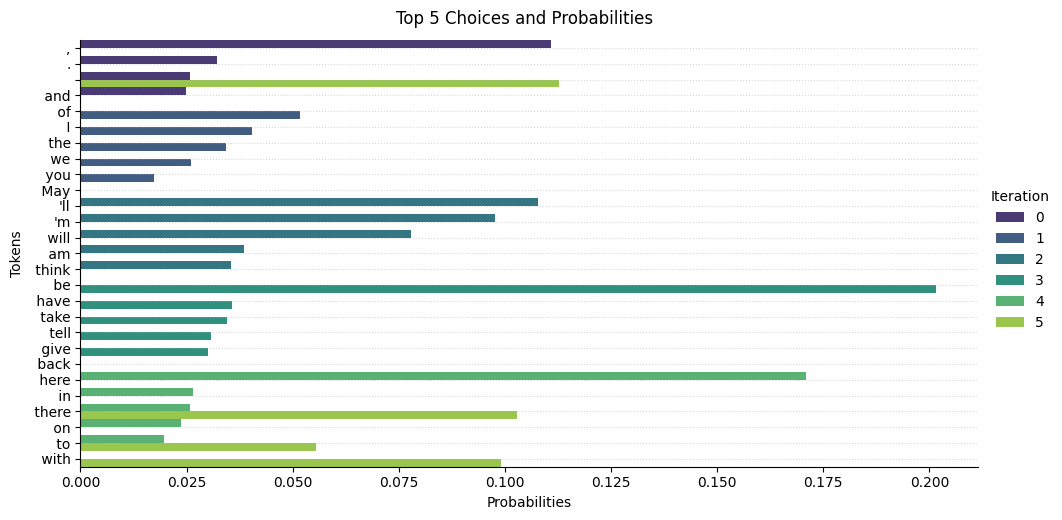

In [9]:
# Plot the top n choices and their probabilities for each iteration
top_n = 5
data = pd.DataFrame()
for i, (logits, probs) in enumerate(zip(all_logits, all_probs)):
    top_n_indices = np.argsort(-logits)[:top_n]
    top_n_tokens = [tokenizer.decode(idx) for idx in top_n_indices]
    top_n_probs = probs[top_n_indices]
    chosen_token = top_n_tokens[0]  # Get the chosen token for this iteration
    
    # Create a dictionary for each iteration containing the relevant data
    iteration_data = {
        "Token": top_n_tokens,
        "Probability": top_n_probs,
        "Iteration": i,
        "Chosen": [token.strip() == chosen_token.strip() for token in top_n_tokens],  # True if token is chosen, False otherwise
        "Chosen Token": [chosen_token] * len(top_n_tokens)  # Mark the chosen token for this iteration
    }

    data = pd.concat([data, pd.DataFrame(iteration_data)])

data.reset_index(drop=True, inplace=True)

# Create the plot
g = sns.catplot(
    x="Probability", y="Token", hue="Iteration", data=data, kind="bar",
    palette="viridis", aspect=2, width=3
)
g.fig.suptitle("Top {} Choices and Probabilities".format(top_n), y=1.03)

for ax in g.axes.flat:
    ax.yaxis.grid(True, linestyle='dotted', alpha=0.5)
    
plt.xlabel("Probabilities")
plt.ylabel("Tokens")
plt.xticks(rotation=0)
plt.show()

Despite being straightforward to implement and computationally efficient, the Greedy Search decoding in generative models has several disadvantages:

1. It only selects the token with the highest probability at each step, which can lead to a lack of exploration. It may get stuck in local optima and miss better options available in the long run.

2. Since greedy search makes decisions based solely on the highest probability at each step, it may produce suboptimal or less diverse outputs. The generated text may lack creativity and variation. It can also potentially ignore low-probability tokens that may be essential for generating coherent and meaningful sequences.

3. It lacks the ability to capture global dependencies between tokens in the output sequence. It only considers local context and may not produce coherent sequences over longer contexts.

4. It generates text with a fixed length determined by the number of iterations. This may not be ideal for tasks where the length of the output needs to be adaptive or variable.

### Beam Search Decoding

Beam search is a more sophisticated decoding method that keeps track of multiple candidate sequences at each step. It explores the most probable candidates based on the model's conditional probabilities, considering all possible next-token extensions of the existing set and selecting the most likely extensions. 

The beam width determines how many candidates are kept at each step. Beam search often produces more diverse and better-quality outputs compared to greedy decoding.

In [16]:
def beam_search_decoding(prompt: str, beam_width: int=5, max_length: int=10):
    # Encode the prompt using the tokenizer
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)

    # Initialize the beam with the seed input
    beam = [(input_ids, 0)]
    print(f"Input: {input_ids}")

    for i in range(max_length):
        # Create a list to store the new beam candidates and their scores
        new_beam = []
        print(f"Iteration {i}")
        
        for current_sequence, current_score in beam:  
            # Generate text using the current sequence
            with torch.no_grad():
                output = model(current_sequence)
                logits = output.logits[:, -1, :]
                log_probs = torch.log_softmax(logits, dim=-1)
                top_k_log_probs, top_k_indices = torch.topk(log_probs, beam_width, dim=-1)
                print(f"Top k: {top_k_indices}")

            # Expand the beam with new candidates
            for k in range(beam_width):
                next_token_id = top_k_indices[0][k].item()
                next_score = current_score + top_k_log_probs[0][k].item()
                new_sequence = torch.cat((current_sequence, torch.tensor([[next_token_id]]).to(model.device)), dim=1)
                new_beam.append((new_sequence, next_score))
                print(f"New seq: {new_sequence.cpu().numpy()}, {next_score}")
                
        # Sort the new beam based on scores and select the top-k candidates
        beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
    # Select the best sequence from the final beam and decode it to text
    best_sequence = beam[0][0]
    print(best_sequence)
    generated_text = tokenizer.decode(best_sequence[0], skip_special_tokens=True)

    return generated_text

prompt = "Tomorrow"
beam_width = 3
generated_text = beam_search_decoding(prompt, beam_width=beam_width, max_length=5)
print("Generated Text:")
print(generated_text)

Input: tensor([[49488]], device='mps:0')
Iteration 0
Top k: tensor([[ 11,  13, 198]], device='mps:0')
New seq: [[49488    11]], -2.1067283153533936
New seq: [[49488    13]], -2.2005412578582764
New seq: [[49488   198]], -3.4393279552459717
Iteration 1
Top k: tensor([[314, 262, 356]], device='mps:0')
New seq: [[49488    11   314]], -5.066730260848999
New seq: [[49488    11   262]], -5.3145787715911865
New seq: [[49488    11   356]], -5.4821507930755615
Top k: tensor([[198, 314, 632]], device='mps:0')
New seq: [[49488    13   198]], -3.723860025405884
New seq: [[49488    13   314]], -5.201826333999634
New seq: [[49488    13   632]], -5.5188353061676025
Top k: tensor([[  198, 50256,   628]], device='mps:0')
New seq: [[49488   198   198]], -3.440059036947787
New seq: [[49488   198 50256]], -13.507671117782593
New seq: [[49488   198   628]], -13.70827841758728
Iteration 2
Top k: tensor([[ 464, 1135,   40]], device='mps:0')
New seq: [[49488   198   198   464]], -6.688568443991244
New seq: [[

In [12]:
class TreeNode:
    def __init__(self, value, sequence, score, parent):
        self.value = value
        self.sequence = sequence
        self.score = score
        self.children = []
        self.parent = parent
        
    def add_child(self, child_node):
        self.children.append(child_node)
        
def beam_search_decoding(prompt: str, beam_width: int=5, max_length: int=10):
    # Encode the prompt using the tokenizer
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)
    
    # Initialize the beam with the seed input   
    root = TreeNode(input_ids, input_ids, 0, None)
    
    current_nodes = [root]

    for _ in range(max_length):
        new_nodes = []

        for current_node in current_nodes:
            current_sequence = current_node.sequence
            current_score = current_node.score
                
            # Generate text using the current sequence
            with torch.no_grad():
                output = model(current_sequence)
                logits = output.logits[:, -1, :]
                log_probs = torch.log_softmax(logits, dim=-1)
                top_k_log_probs, top_k_indices = torch.topk(log_probs, beam_width, dim=-1)

            # Expand the beam with new candidates      
            for k in range(beam_width):
                next_token_id = top_k_indices[0][k].item()
                next_score = current_score + top_k_log_probs[0][k].item()
                new_sequence = torch.cat((current_sequence, torch.tensor([[next_token_id]]).to(model.device)), dim=1)
                new_value = torch.tensor([[next_token_id]]).to(model.device)
                new_node = TreeNode(new_value, new_sequence, next_score, current_node)
                current_node.add_child(new_node)
                new_nodes.append(new_node)

        # Sort the new beam candidates based on scores and select the top-k candidates
        new_nodes.sort(key=lambda x: x.score, reverse=True)
        current_nodes = new_nodes[:beam_width]
        
    # Find the best sequence from the last iteration
    best_sequence_node = max(new_nodes, key=lambda node: node.score)

    return root, best_sequence_node


prompt = "Tomorrow"
beam_width = 3
root, best_sequence_node = beam_search_decoding(prompt, beam_width=beam_width, max_length=5)
print("Best Sequence:", best_sequence_node.sequence, "Score:", best_sequence_node.score)
tokenizer.decode(best_sequence_node.sequence[0].tolist(), skip_special_tokens=True)

Best Sequence: tensor([[49488,    13,   198,   198,     1,    40]], device='mps:0') Score: -8.759859218262136


'Tomorrow.\n\n"I'

In [13]:
def print_tree(node: TreeNode, indent: str=""):
    print(indent + f"Value: {node.value}, Score: {node.score}")
    for child in node.children:
        print_tree(child, indent + "  ")
        
        
print_tree(root)

Value: tensor([[49488]], device='mps:0'), Score: 0
  Value: tensor([[11]], device='mps:0'), Score: -2.1067283153533936
    Value: tensor([[314]], device='mps:0'), Score: -5.066730260848999
      Value: tensor([[1183]], device='mps:0'), Score: -7.29378604888916
        Value: tensor([[307]], device='mps:0'), Score: -8.896062850952148
        Value: tensor([[423]], device='mps:0'), Score: -10.626562118530273
        Value: tensor([[1011]], device='mps:0'), Score: -10.657384872436523
      Value: tensor([[1101]], device='mps:0'), Score: -7.393990516662598
      Value: tensor([[481]], device='mps:0'), Score: -7.620171546936035
    Value: tensor([[262]], device='mps:0'), Score: -5.3145787715911865
    Value: tensor([[356]], device='mps:0'), Score: -5.4821507930755615
  Value: tensor([[13]], device='mps:0'), Score: -2.2005412578582764
    Value: tensor([[198]], device='mps:0'), Score: -3.723860025405884
      Value: tensor([[198]], device='mps:0'), Score: -3.728587402962148
        Value: te

/var/folders/ft/ls6l6dtj6hd7bxnsz5sg1vz00000gn/T/ipykernel_88593/696397344.py:85: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='coolwarm'), orientation='vertical', label='Scores')


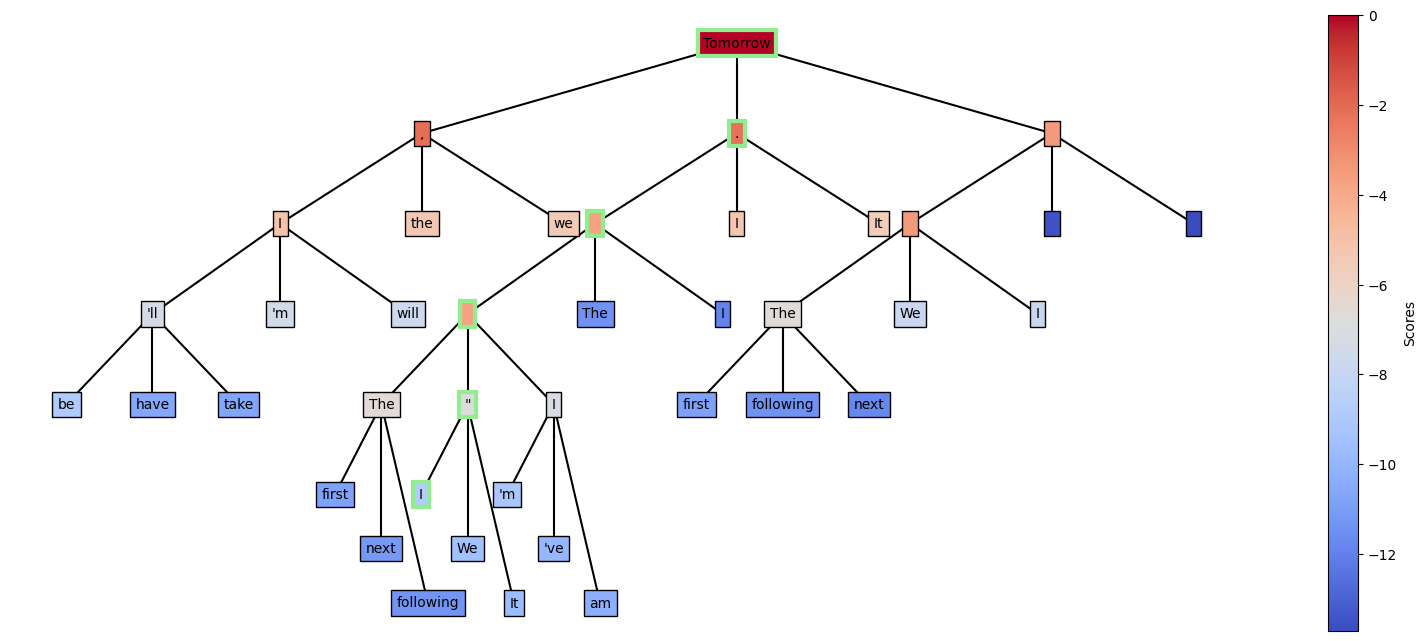

In [14]:
def count_nodes_per_level(root: TreeNode) -> int:
    nodes_per_level = [0] * get_max_depth(root)

    def traverse(node, level):
        nodes_per_level[level] += 1
        for child in node.children:
            traverse(child, level + 1)

    traverse(root, 0)
    return nodes_per_level

def get_max_depth(node: TreeNode) -> int:
    if not node.children:
        return 1
    return max(get_max_depth(child) + 1 for child in node.children)

def flatten_tree(node: TreeNode) -> list:
    flattened = []
    stack = [node]
    while stack:
        current = stack.pop()
        flattened.append(current)
        stack.extend(current.children)
    return flattened

def draw_tree(node: TreeNode, x: int, y:int, dx: float, dy: float, level=0, best_sequence=None):
    """
    dx: This is the horizontal spacing between sibling nodes at the same level. 
    It determines how far apart the nodes are from each other along the x-axis.
    dy: This is the vertical spacing between parent and child nodes. 
    It determines how far down the child nodes are placed relative to their parent along the y-axis.
    """
    if not node:
        return

    text = tokenizer.decode(node.value[0].tolist(), skip_special_tokens=True).strip()
    if text == "":
        text = " "
    
    # Calculate color based on score using a colormap
    cmap = plt.get_cmap('coolwarm')  # Choose a colormap (you can use any other colormap)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)  # Define the color scale based on score range
    color = cmap(norm(node.score))

    # Draw the node with color based on score
    edgecolor = 'black'
    linewidth=1
    if best_sequence is not None and torch.equal(node.sequence[0], best_sequence.sequence[0][:level+1]):
        edgecolor = 'lightgreen'
        linewidth=3
        
    plt.text(x, y, text, ha='center', va='center', bbox=dict(facecolor=color, edgecolor=edgecolor, linewidth=linewidth))
    
    num_children = len(node.children)
    if num_children > 0:
        # Calculate the spacing factor based on the level and number of children
        # The factor increases at lower levels or with more children, 
        # and decreases closer to the root with fewer children
        spacing_factor = 0.3 * (nodes_per_level[level] / (level + 1))
        # The x_start coordinate is calculated using the current x coordinate,
        # the total number of children, the adjusted dx spacing factor, and the index i.
        # This calculation distributes the children horizontally with proper spacing.
        x_start = x - (num_children - 1) * dx * spacing_factor / 2 
        for i, child in enumerate(node.children):
            # The plt.plot() call now connects the current node (x, y) 
            # to the child node (x_start, y - dy) using a line. 
            # This is achieved by adjusting the x and y coordinates accordingly.
            if dx * spacing_factor <= 0.03:
                n_dy = dy + dy * 0.6 * i
                plt.plot([x, x_start], [y, y - n_dy], '-k')
                draw_tree(child, x_start, y - n_dy, dx * spacing_factor, dy, level + 1, best_sequence)
            else:
                plt.plot([x, x_start], [y, y - dy], '-k')
                draw_tree(child, x_start, y - dy, dx * spacing_factor, dy, level + 1, best_sequence)
            x_start += dx * spacing_factor

nodes_per_level = count_nodes_per_level(root)

# Calculate vmin and vmax based on the tree scores
vmin = min(node.score for node in flatten_tree(root))
vmax = max(node.score for node in flatten_tree(root))

plt.figure(figsize=(20, 8))
draw_tree(root, x=0, y=0, dx=0.4, dy=2, best_sequence=best_sequence_node)
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='coolwarm'), orientation='vertical', label='Scores')
plt.axis('off')
plt.show()

As can be seen, this method also suffers from repetitive text. One way to overcome this is to apply a technique called _n-gram penalty_. This technique discourages the repetition of specific subsequences of words (n-grams) in generated text. It is often applied to improve the diversity and coherence of generated content. The basic idea is to penalize the generation of sequences that contain repeated n-grams, which can lead to monotonous or less natural-sounding output.

In [17]:
def calculate_ngram_penalty(sequence: torch.Tensor, n: int) -> float:
    ngrams = set()
    penalty = 0
    for i in range(len(sequence) - n + 1):
        ngram = tuple(sequence[i:i + n].tolist())
        if ngram in ngrams:
            penalty += 1
        ngrams.add(ngram)
    return penalty

def beam_search_decoding(prompt: str, beam_width: int=5, max_length: int=10):
    # Encode the prompt using the tokenizer
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)
    
    # Initialize the beam with the seed input   
    root = TreeNode(input_ids, input_ids, 0, None)
    
    current_nodes = [root]

    for _ in range(max_length):
        new_nodes = []

        for current_node in current_nodes:
            current_sequence = current_node.sequence
            current_score = current_node.score
                
            # Generate text using the current sequence
            with torch.no_grad():
                output = model(current_sequence)
                logits = output.logits[:, -1, :]
                log_probs = torch.log_softmax(logits, dim=-1)
                top_k_log_probs, top_k_indices = torch.topk(log_probs, beam_width, dim=-1)

            # Expand the beam with new candidates      
            for k in range(beam_width):
                next_token_id = top_k_indices[0][k].item()
                new_sequence = torch.cat((current_sequence, torch.tensor([[next_token_id]]).to(model.device)), dim=1)
                new_value = torch.tensor([[next_token_id]]).to(model.device)
                ngram_penalty = calculate_ngram_penalty(new_sequence[0], n=1)  # Choose the desired n-gram length
                next_score = current_score + top_k_log_probs[0][k].item() - ngram_penalty  # Apply the penalty
                new_node = TreeNode(new_value, new_sequence, next_score, current_node)
                current_node.add_child(new_node)
                new_nodes.append(new_node)

        # Sort the new beam candidates based on scores and select the top-k candidates
        new_nodes.sort(key=lambda x: x.score, reverse=True)
        current_nodes = new_nodes[:beam_width]
        
    # Find the best sequence from the last iteration
    best_sequence_node = max(new_nodes, key=lambda node: node.score)

    return root, best_sequence_node


prompt = "Tomorrow"
beam_width = 3
root, best_sequence_node = beam_search_decoding(prompt, beam_width=beam_width, max_length=5)
print("Best Sequence:", best_sequence_node.sequence, "Score:", best_sequence_node.score)
tokenizer.decode(best_sequence_node.sequence[0].tolist(), skip_special_tokens=True)

Best Sequence: tensor([[49488,    11,   314,  1183,   307,   736]], device='mps:0') Score: -10.662545204162598


"Tomorrow, I'll be back"

/var/folders/ft/ls6l6dtj6hd7bxnsz5sg1vz00000gn/T/ipykernel_88593/1272800907.py:3: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='coolwarm'), orientation='vertical', label='Scores')


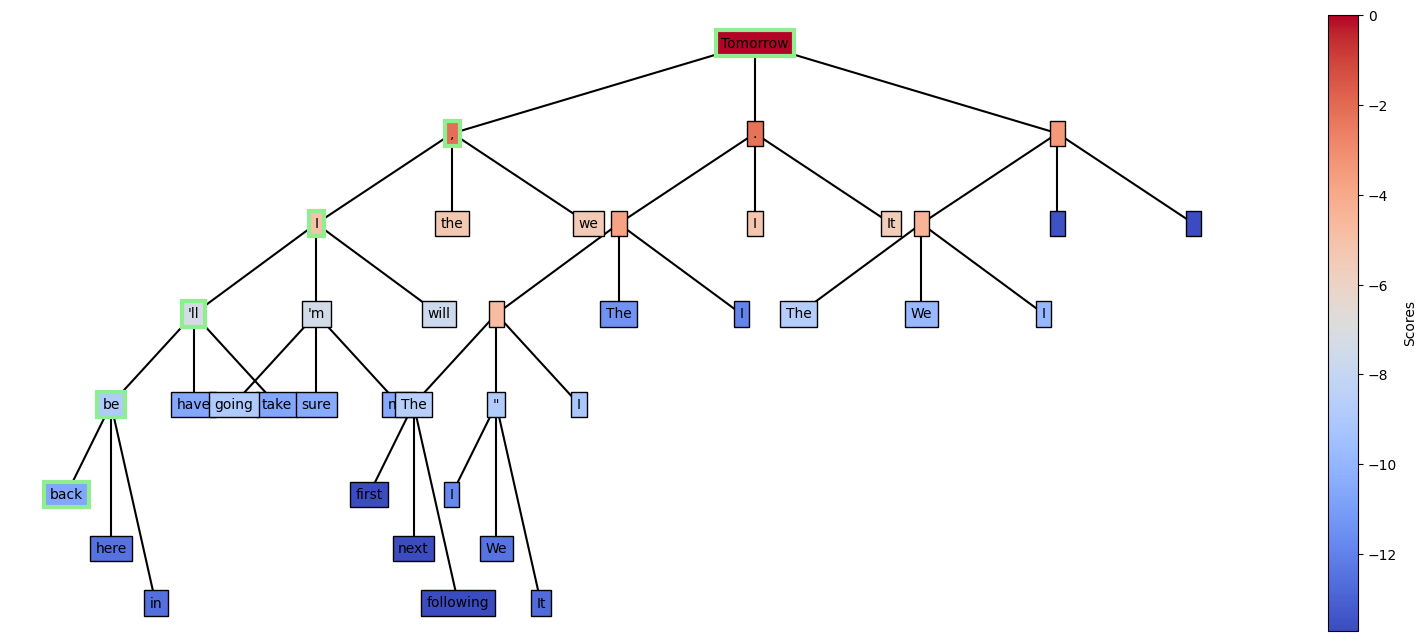

In [18]:
plt.figure(figsize=(20, 8))
draw_tree(root, x=0, y=0, dx=0.4, dy=2, best_sequence=best_sequence_node)
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='coolwarm'), orientation='vertical', label='Scores')
plt.axis('off');

Some of the advantages of the Beam Search are:

1. **Improved Quality of Generated Text**: It generally produces higher-quality generated sequences compared to greedy search, as it considers multiple candidate sequences at each step. This can lead to more coherent and fluent generated text.

2. **Increased Likelihood of Finding Global Optimum**: It explores multiple possible sequences in parallel, increasing the likelihood of finding the globally optimal sequence or a close approximation to it.

3. **Flexible Beam Width**: The beam width parameter in beam search allows control over the number of candidate sequences considered at each step. Adjusting the beam width allows for a trade-off between exploration and exploitation, providing a balance between diversity and quality.

On the other hand, some of the disadvantages are:

1. **Exponential Search Space**: The number of candidate sequences explored at each step grows exponentially with the beam width, which can lead to significant computational overhead, especially when using larger beam widths or longer sequences.

2. **Local Optima**: While beam search aims to find the optimal sequence, it may sometimes get stuck in local optima, resulting in suboptimal or repetitive generated text.

3. **Lack of Diversity**: Beam search can suffer from a lack of diversity in generated output, as it often converges to similar sequences due to its deterministic nature. 

4. **Limited Exploration**: The beam search algorithm explores a limited set of candidates at each step, potentially missing out on other valid but less likely sequences that may have higher scores in the long run.

To address some of these limitations and achieve better trade-offs between quality, diversity, and efficiency, another alternative is to use sampling methods.

### Sampling Methods

The most basic way to perform sampling is by randomly selecting from the probability distribution of the model's generated outputs across the entire set of possible words in the vocabulary for each time step:

$$P(y_t=w_i | y_{<t}, \mathbf{x}) = \mathrm{softmax}(z_{t, i}) = \frac{\exp(z_{t, i})}{\sum_{j=1}^{|V|}{\exp(z_{t, j})}}$$

where $|V|$ denotes the size of the vocabulary. The diversity of the output can be controlled using a temperature parameter $T$ that rescales the logits before taking the softmax such as:

$$P(y_t=w_i | y_{<t}, \mathbf{x}) = \mathrm{softmax}(z_{t, i}) = \frac{\exp(z_{t, i}/T)}{\sum_{j=1}^{|V|}{\exp(z_{t, j}/T)}}$$

The temperature parameter acts controlling the randomness of the sampling process. A higher temperature value (greater than 1) makes the sampling more diverse and random, while a lower temperature value (less than 1) makes the sampling more focused and deterministic.

When we apply temperature scaling to the logits before applying the softmax function, we are essentially adjusting the shape of the probability distribution over the vocabulary. Higher temperature values make the logits closer in value, which results in a flatter probability distribution, where more tokens have a higher probability of being chosen. Lower temperature values make the logits more distinct, which leads to a sharper probability distribution, with fewer tokens having high probabilities.

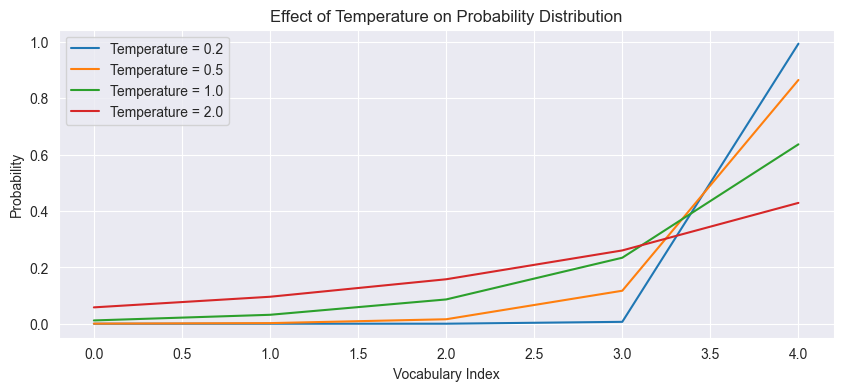

In [17]:
def plot_probability_distribution(logits: torch.Tensor, temperature_values: list[float]) -> None:
    plt.figure(figsize=(10, 4))
    
    for temperature in temperature_values:
        scaled_logits = logits / temperature
        probs = torch.softmax(scaled_logits, dim=-1)
        
        plt.plot(probs[0].cpu().numpy(), label=f"Temperature = {temperature:.1f}")

    plt.xlabel("Vocabulary Index")
    plt.ylabel("Probability")
    plt.title("Effect of Temperature on Probability Distribution")
    plt.legend()

# Example logits for a specific token (shape: [batch_size, vocab_size])
logits = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0]])

# Different temperature values to visualize
temperature_values = [0.2, 0.5, 1.0, 2.0]

plot_probability_distribution(logits, temperature_values)

In [18]:
def generate_with_sampling(prompt: str, temperature: float=1, max_length: int=10):
    # Encode the prompt using the tokenizer
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)
    
    # Initialize lists to store the generated tokens, logits, and probabilities
    generated_tokens = input_ids.tolist()[0]
    
    # Generate text using sampling
    with torch.no_grad():
        for i in range(max_length): 
            output = model(input_ids)

            # Extract the logits for the generated text
            logits = output.logits[:, -1, :]

            # Apply temperature scaling to the logits
            scaled_logits = logits / temperature

            # Apply softmax to the scaled logits to get a probability distribution
            probabilities = torch.softmax(scaled_logits, dim=-1)

            # Sample from the probability distribution
            sampled_token = torch.multinomial(probabilities, num_samples=1)

            # Append the new token to the list of generated tokens
            generated_tokens.append(sampled_token.item())

            # Update the input_ids for the next iteration
            input_ids = sampled_token  # Update input_ids with the sampled token

            print(f"Iteration {i}: {generated_tokens}")
    
    # Decode the generated output to text
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    print(f"Generated text: {generated_text}")

Notice the difference on the update of `input_ids`:

1. In the `generate_with_greedy_search` function, we choose the token with the highest logit value as the next token in each iteration. We append this token to the `input_ids` tensor using concatenation to update the sequence for the next iteration. Here, we want to keep track of the entire sequence of tokens generated so far, and we update `input_ids` to include this new token.

2. In the `generate_with_sampling` function, we sample a token from the probability distribution over the vocabulary based on the scaled logits. In each iteration, we sample a token and update the `input_ids` tensor to include only this sampled token, discarding the previous sequence. 

The choice between concatenation and direct replacement of `input_ids` depends on the decoding strategy used. In greedy search, we iteratively build the sequence, while in random sampling, we replace the sequence with the sampled token in each step.

In [19]:
prompt = "Tomorrow"
generate_with_sampling(prompt, temperature=1)

Iteration 0: [49488, 26]
Iteration 1: [49488, 26, 632]
Iteration 2: [49488, 26, 632, 284]
Iteration 3: [49488, 26, 632, 284, 15300]
Iteration 4: [49488, 26, 632, 284, 15300, 30830]
Iteration 5: [49488, 26, 632, 284, 15300, 30830, 13]
Iteration 6: [49488, 26, 632, 284, 15300, 30830, 13, 8]
Iteration 7: [49488, 26, 632, 284, 15300, 30830, 13, 8, 691]
Iteration 8: [49488, 26, 632, 284, 15300, 30830, 13, 8, 691, 838]
Iteration 9: [49488, 26, 632, 284, 15300, 30830, 13, 8, 691, 838, 12]
Generated text: Tomorrow; It to Selicht.) only 10-


In [24]:
prompt = "Tomorrow"
generate_with_sampling(prompt, temperature=1.5)

Iteration 0: [49488, 1751]
Iteration 1: [49488, 1751, 1303]
Iteration 2: [49488, 1751, 1303, 21190]
Iteration 3: [49488, 1751, 1303, 21190, 764]
Iteration 4: [49488, 1751, 1303, 21190, 764, 38025]
Iteration 5: [49488, 1751, 1303, 21190, 764, 38025, 3576]
Iteration 6: [49488, 1751, 1303, 21190, 764, 38025, 3576, 7718]
Iteration 7: [49488, 1751, 1303, 21190, 764, 38025, 3576, 7718, 18812]
Iteration 8: [49488, 1751, 1303, 21190, 764, 38025, 3576, 7718, 18812, 13288]
Iteration 9: [49488, 1751, 1303, 21190, 764, 38025, 3576, 7718, 18812, 13288, 18094]
Generated text: Tomorrow children # balloon.Christopher Londoncar precipproof certification


In [21]:
prompt = "Tomorrow"
generate_with_sampling(prompt, temperature=0.0)

Iteration 0: [49488, 0]
Iteration 1: [49488, 0, 0]
Iteration 2: [49488, 0, 0, 0]
Iteration 3: [49488, 0, 0, 0, 0]
Iteration 4: [49488, 0, 0, 0, 0, 0]
Iteration 5: [49488, 0, 0, 0, 0, 0, 0]
Iteration 6: [49488, 0, 0, 0, 0, 0, 0, 0]
Iteration 7: [49488, 0, 0, 0, 0, 0, 0, 0, 0]
Iteration 8: [49488, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Iteration 9: [49488, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generated text: Tomorrow!!!!!!!!!!


In practice, setting a high or low temperature value in text generation involves trade-offs between coherence and diversity:

**High Temperature (Randomness):**
- **Advantages:**
  - Generates more diverse and creative output.
  - Encourages the model to explore different word choices and combinations.
  - Can lead to unexpected and interesting variations in the generated text.
- **Disadvantages:**
  - Output may become less coherent and logical.
  - May introduce grammatical errors or nonsensical sequences.
  - Could include rare or unusual words that are unlikely in typical contexts.
  - May produce less focused and relevant results for specific tasks.

**Low Temperature (Determinism):**
- **Advantages:**
  - Generates more focused and deterministic output.
  - Increases the likelihood of selecting high-probability words and common sequences.
  - Tends to produce coherent and grammatically correct text.
  - Useful for tasks that require precise and controlled language generation.
- **Disadvantages:**
  - Output can become repetitive and lack creativity.
  - Limits exploration of alternative word choices and structures.
  - May produce predictable and less engaging text.
  - Can result in a lack of diversity in the generated content.
  
To address some of these issues, Top-k and Nucleus Sampling extend basic sampling by introducing controlled mechanisms to select tokens during text generation. 


#### Top K Sampling

Top-k sampling works by avoiding low-probability choices, narrowing down the selection to the top-k tokens with the highest probabilities.
It involves sorting the probability distribution and selecting from the top-k tokens, where k is a predefined threshold.
This approach maintains randomness while focusing on a smaller set of likely choices, leading to more coherent and contextually relevant output. It helps to avoid generating very unlikely or irrelevant tokens.

In [42]:
def generate_with_top_k_sampling(prompt: str, top_k: int=10000, temperature: float=1.0, max_length: int=10):
    # Encode the prompt using the tokenizer
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    
    # Generate text using top-k sampling
    with torch.no_grad():
        for i in range(max_length):
            output = model(input_ids)
            
            # Extract the logits for the generated text
            logits = output.logits[:, -1, :]
            
            # Apply temperature scaling to the logits
            scaled_logits = logits / temperature
            
            # Apply softmax to the scaled logits to get a probability distribution
            probabilities = torch.softmax(scaled_logits, dim=-1)
            
            # Apply top-k sampling to select candidate tokens
            sorted_probs, sorted_indices = torch.topk(probabilities, k=top_k, dim=-1)
            
            # Select the next token based on top-k probabilities
            next_token_id = torch.multinomial(sorted_probs, num_samples=1)
            next_token_id = sorted_indices[0, next_token_id.item()].item()
            
            # Append the new token to the input_ids sequence
            input_ids = torch.cat((input_ids, torch.tensor([[next_token_id]], device=model.device)), dim=1)
            
            # Decode the generated output to text
            generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            print(f"Iteration {i}: {generated_text}")
    
    # Decode the final generated output to text
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    print(f"Generated Text: {generated_text}")

prompt = "Tomorrow"
generate_with_top_k_sampling(prompt)

Iteration 0: Tomorrow appears
Iteration 1: Tomorrow appears to
Iteration 2: Tomorrow appears to have
Iteration 3: Tomorrow appears to have arrived
Iteration 4: Tomorrow appears to have arrived here
Iteration 5: Tomorrow appears to have arrived here,
Iteration 6: Tomorrow appears to have arrived here, and
Iteration 7: Tomorrow appears to have arrived here, and with
Iteration 8: Tomorrow appears to have arrived here, and with it
Iteration 9: Tomorrow appears to have arrived here, and with it the
Generated Text: Tomorrow appears to have arrived here, and with it the


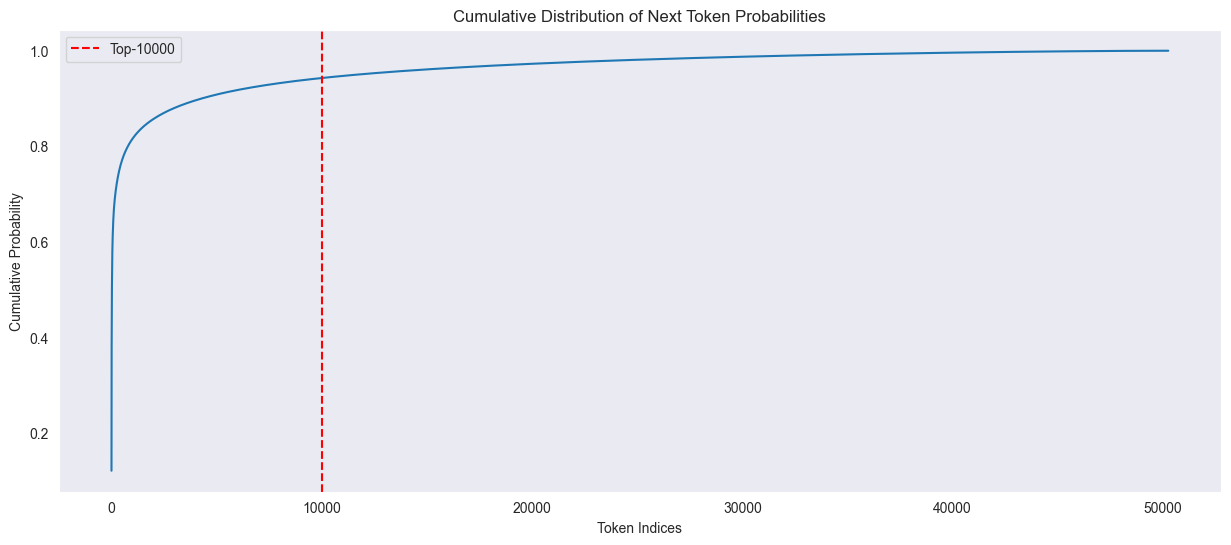

In [43]:
def visualize_top_k_sampling(prompt: str, top_k: int = 10, temperature: float = 1.0) -> None:
    # Encode the prompt using the tokenizer
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    
    # Create a figure for visualization
    plt.figure(figsize=(15, 6))
    with torch.no_grad():
        output = model(input_ids)
            
        # Extract the logits for the generated text
        logits = output.logits[:, -1, :]
        
        # Apply temperature scaling to the logits
        scaled_logits = logits / temperature
        
        # Apply softmax to the scaled logits to get a probability distribution
        probabilities = torch.softmax(scaled_logits, dim=-1)
        
        # Get the sorted probabilities and their corresponding indices
        sorted_probs, sorted_indices = torch.sort(probabilities, descending=True, dim=-1)
        
        # Calculate the cumulative distribution of probabilities
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        
        # Create a cumulative distribution plot with a vertical line at top_k
        plt.plot(np.arange(len(cumulative_probs[0])), cumulative_probs[0].cpu().numpy())
        plt.axvline(x=top_k, color='r', linestyle='--', label=f'Top-{top_k}')
        plt.xlabel("Token Indices")
        plt.ylabel("Cumulative Probability")
        plt.title("Cumulative Distribution of Next Token Probabilities")
        plt.legend()
        plt.grid()

prompt = "Tomorrow"
visualize_top_k_sampling(prompt, top_k=10000)

#### Nucleus (Top-p) Sampling:

In nucleus (or top-p) sampling, we set a threshold probability `p` and select from the smallest set of tokens whose cumulative probability exceeds `p`. I.e, unlike Top-k sampling, nucleus sampling considers a dynamic set of candidate tokens based on their cumulative probabilities, rather than a fixed number.
It allows for a more flexible and adaptive way of controlling randomness.
Nucleus sampling ensures a balance between randomness and diversity by capturing a broader range of tokens with higher probabilities.

In [44]:
def generate_with_nucleus_sampling(prompt: str, top_p: float = 0.9, temperature: float = 1.0, max_length: int = 10):
    # Encode the prompt using the tokenizer
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    
    # Generate text using nucleus (top p) sampling
    with torch.no_grad():
        for i in range(max_length):
            output = model(input_ids)
            
            # Extract the logits for the generated text
            logits = output.logits[:, -1, :]
            
            # Apply temperature scaling to the logits
            scaled_logits = logits / temperature
            
            # Apply softmax to the scaled logits to get a probability distribution
            probabilities = torch.softmax(scaled_logits, dim=-1)
            
            # Sort the probabilities in descending order
            sorted_probs, sorted_indices = torch.sort(probabilities, descending=True, dim=-1)
            
            # Calculate cumulative probabilities
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            
            # Determine the threshold position based on top p
            mask = cumulative_probs < top_p
            threshold_position = torch.sum(mask.long(), dim=-1)
            
            # Select the next token based on nucleus probabilities
            next_token_id = torch.multinomial(sorted_probs, num_samples=1)
            next_token_id = sorted_indices[0, next_token_id.item()].item()
            
            # Append the new token to the input_ids sequence
            input_ids = torch.cat((input_ids, torch.tensor([[next_token_id]], device=model.device)), dim=1)
            
            # Decode the generated output to text
            generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            print(f"Iteration {i}: {generated_text}")
    
    # Decode the final generated output to text
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    print(f"Generated Text: {generated_text}")

prompt = "Tomorrow"
generate_with_nucleus_sampling(prompt)

/var/folders/ft/ls6l6dtj6hd7bxnsz5sg1vz00000gn/T/ipykernel_40166/872143094.py:27: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  threshold_position = torch.sum(mask.long(), dim=-1)


Iteration 0: Tomorrow-
Iteration 1: Tomorrow-night
Iteration 2: Tomorrow-night,
Iteration 3: Tomorrow-night, on
Iteration 4: Tomorrow-night, on a
Iteration 5: Tomorrow-night, on a particular
Iteration 6: Tomorrow-night, on a particular subway
Iteration 7: Tomorrow-night, on a particular subway of
Iteration 8: Tomorrow-night, on a particular subway of western
Iteration 9: Tomorrow-night, on a particular subway of western Michigan
Final Generated Text: Tomorrow-night, on a particular subway of western Michigan


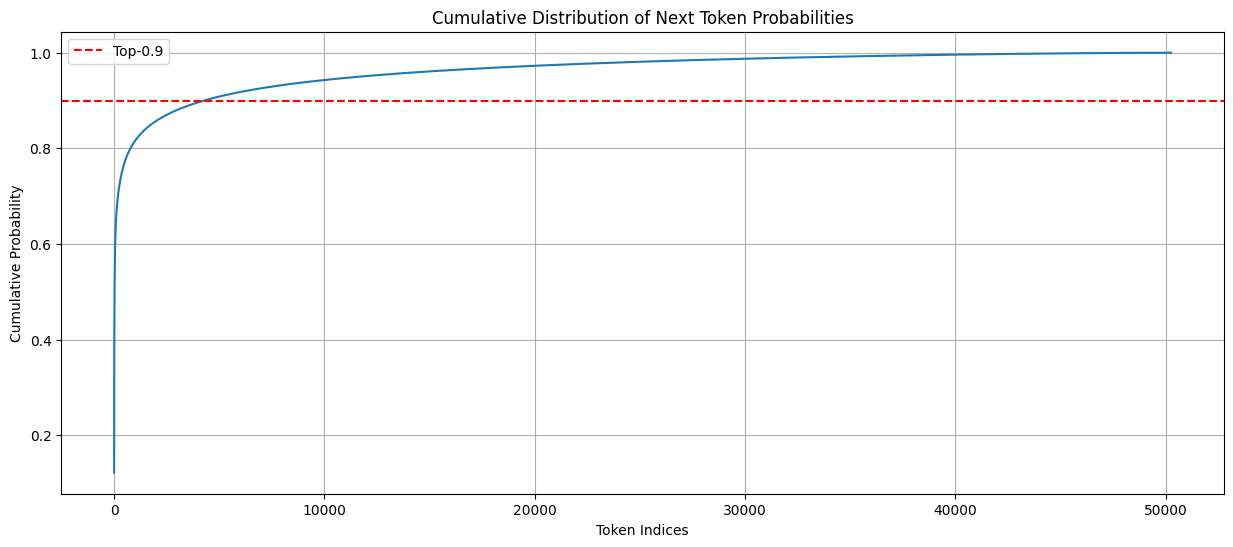

In [56]:
def visualize_top_p_sampling(prompt: str, top_p: float = 0.9, temperature: float = 1.0) -> None:
    # Encode the prompt using the tokenizer
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    
    # Create a figure for visualization
    plt.figure(figsize=(15, 6))
    with torch.no_grad():
        output = model(input_ids)
            
        # Extract the logits for the generated text
        logits = output.logits[:, -1, :]
        
        # Apply temperature scaling to the logits
        scaled_logits = logits / temperature
        
        # Apply softmax to the scaled logits to get a probability distribution
        probabilities = torch.softmax(scaled_logits, dim=-1)
        
        # Get the sorted probabilities and their corresponding indices
        sorted_probs, sorted_indices = torch.sort(probabilities, descending=True, dim=-1)
        
        # Calculate the cumulative distribution of probabilities
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        
        # Create a cumulative distribution plot with a vertical line at top_k
        plt.plot(np.arange(len(cumulative_probs[0])), cumulative_probs[0].cpu().numpy())
        plt.axhline(y=top_p, color='r', linestyle='--', label=f'Top-{top_p}')
        plt.xlabel("Token Indices")
        plt.ylabel("Cumulative Probability")
        plt.title("Cumulative Distribution of Next Token Probabilities")
        plt.legend()
        plt.grid()

prompt = "Tomorrow"
visualize_top_p_sampling(prompt)

Choosing the best decoding method depends on the specific task, goals, and preferences. Each decoding method has its own characteristics, advantages, and limitations:

1. Greedy Decoding:
    - Advantages: Simple and efficient. Can generate coherent and fluent text.
    - Limitations: Can lead to repetitive and overly deterministic outputs. Lack of diversity.
2. Beam Search:
    - Advantages: Considers multiple candidates, resulting in diverse outputs. Can produce high-quality text.
    - Limitations: Computationally expensive. Still tends to produce repetitive outputs. Beam width needs to be carefully chosen.
3. Sampling (Temperature, Top-k, Top-p):
    - Advantages: Can produce more diverse and creative text. Temperature controls randomness, top-k avoids repetition, and top-p controls diversity.
    - Limitations: May lead to less coherent or fluent text. Requires tuning hyperparameters for desired output quality.
4. Custom Strategies or Hybrid Approaches:
    - Advantages: Allows you to combine multiple decoding methods to achieve specific goals. Can mitigate the limitations of individual methods.
    - Limitations: May require more complex implementation and parameter tuning.